In [1]:
from __future__ import print_function                                                                                                                                
import sys
import os
import gc
from copy import deepcopy
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as LA
import scipy.sparse as sp
from modules.convert_parameters import get_kp_model, angstrom_par
from modules.kp_model.kp_model import kp_model
import modules.axial_approximation.axial_kane_model as akm
from modules.kp_model.utils import kp_from_sympy, getpath, calcEpath, getdist, sigma
from modules.kp_model.tb_model import tb_model
from modules.wire import wire_factory
from IPython.display import display, Math, Latex
import sympy
sympy.init_printing()

In [2]:
## ------------------ wire parameters ----------------------
latc    = 10     # lattice constant for discretization
nlayerx = 40     # dimension in x-direction: nlayerx*latc
nlayery = 36     # dimension in y-direction: nlayery*latc
Vd   = 0e-3      # electric field, in eV/Angstrom
Bs   = 1e-6      # scalar value of magnetic field
Bv  = np.array([0.,0.,1.])   # axial direction of the wire
tiltE  = 0/360*2*np.pi  # angle of electric field to y-axis (always perpendicular to z-axis)
tiltB  = 0/360*2*np.pi  # angle of magnetic field to Bv (always perpendicular to y-axis)

ex = np.array([1.,0.,0.])
ey = np.array([0.,1.,0.])
bv = np.cos(tiltB)*Bv+np.sin(tiltB)*ex
par = angstrom_par(B=Bs*bv,gamma_0=5,material='InSb')    
par

{'B_y': 0.0,
 'gamma_0': 5,
 'gamma_1': 7.0319000398136993,
 'B_z': 9.9999999999999995e-07,
 m_0: 5.685630060215049e-30,
 'E_0': 0.237,
 'P': 9.0250425806218111,
 hbar: 6.5821195139999995e-15,
 'gamma_3': 2.6659500199068482,
 'g': -5.0362923252131822,
 'E_v': -0.237,
 'epsilon': 16.8,
 'gamma_2': 1.4659500199068489,
 'Delta': 0.81,
 mu_B: 5.7883818012e-05,
 'B_x': 0.0,
 'kappa': 0.56595001990684857}

In [3]:
## ------------------- kp model -------------------                                                                                         
kp = get_kp_model(par=par)

In [4]:
## ------------------- make wire -----------------    

_, _, center, wire_kpd = wire_factory(kp, latc = latc, nlayerx=nlayerx, nlayery=nlayery, shape='rectangular')

## add electromagnetic potential
Av  = np.cross(Bs*bv,ey)
vector_potential = lambda pos: Av*np.dot(ey,pos)
Ev = np.cos(tiltE)*ey+np.sin(tiltE)*ex
scalar_potential = lambda pos: Vd*(np.dot(pos,Ev)-np.dot(center,Ev))
wire_kpd.add_vector_potential(vector_potential)
wire_kpd.add_scalar_potential(scalar_potential)

S_op = sp.kron(sp.eye(wire_kpd.norb//kp.N),
               Bv[0]*LA.block_diag(sigma.x,np.zeros((6,6)))+
               Bv[1]*LA.block_diag(sigma.y,np.zeros((6,6)))+
               Bv[2]*LA.block_diag(sigma.z,np.zeros((6,6))))

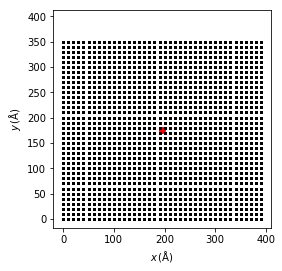

In [5]:
##  -------------------- plot crosssection  --------------------                                                                                                     
plt.figure()
plt.plot(np.dot(ex,center),np.dot(ey,center),'ro')
plt.plot([np.dot(ex,pos) for pos in wire_kpd.lat.p],[np.dot(ey,pos) for pos in wire_kpd.lat.p],'k.',mec='none')
plt.axis('square')
plt.xlabel(r'$x\,(\mathrm{\AA})$')
plt.ylabel(r'$y\,(\mathrm{\AA})$')
plt.show()

In [6]:
##  -------------------- solve wire  --------------------                                                                                                     
nsparse = min(20,wire_kpd.norb-2)
E,V  = sp.linalg.eigsh(sp.csc_matrix(wire_kpd.H([0,0,0],sparse=True)),k=nsparse,tol=1e-6,sigma=0)
gc.collect()

log = E > 0
E = E[log]
V = V[:,log]
ind = np.argsort(E)
E = E[ind]
V = V[:,ind]
S = np.diag(np.dot(V.T.conj(), S_op.dot(V))).real

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

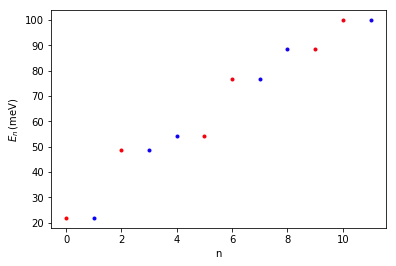

In [7]:
## -------------------- show energy levels -------------------- 
gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(Bs)/5.788382e-5
display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
display(Latex('$\Delta E_1 = {:0.2f}\,$meV'.format((E[4]-E[2])*1e3)))

plt.figure()
S1c = (S+1.0001)/2.0002
for i in range(12):
    plt.plot(i,1e3*E[i],'.',color=(S1c[i],0,1-S1c[i]))
plt.ylabel(r'$E_n\,(\mathrm{meV})$')
plt.xlabel(r'n')
plt.show()

In [ ]:
##  -------------------- plot wavefunction  --------------------  
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
x,y = np.array([np.dot(ex,pos) for pos in wire_kpd.lat.p]),np.array([np.dot(ey,pos) for pos in wire_kpd.lat.p])

for i,nE in enumerate(range(0,12,2)):
    z = np.abs(V[:,nE])**2                                                                                                    
    # make elements unique                                                                                                                                           
    unique_weights = {}
    for xi,yi,zi in zip(x,y,z):
        xi = np.round(xi,4)
        yi = np.round(yi,4)
        try:
            unique_weights[(xi,yi)] += zi
        except:
            unique_weights.update({(xi,yi) : zi})
    pos = []
    weights = []
    for key, value in unique_weights.items():
        pos.append(key)
        weights.append(value)
    pos     = np.array(pos)
    weights = np.array(weights)

    ax = axes[nE//4,(nE//2)%2]
    c = ax.tripcolor(pos[:,0],pos[:,1],weights)
    c.set_rasterized(True)
    ax.axis('equal')
    ax.set_xlim([np.min(pos[:,0]),np.max(pos[:,0])])
    ax.set_ylim([np.min(pos[:,1]),np.max(pos[:,1])])
    ax.axis('off')
    ax.set_title('$ E = {0:.2f}\,meV,\ g = {1:.2f}$'.format(1e3*E[nE],gfactors[nE//2]))
plt.show()